# Plant Pathology 2021 - FGVC8

### What is this competition about?

Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Let's import some libraries!

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
import cv2
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfadd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionResNetV2

Now, we will set the data directories for images and datasets

In [2]:
train_data = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
test_data = pd.read_csv('/kaggle/input/plants/test.csv')
TRAIN_IMG_DIR = '../input/plant-pathology-2021-fgvc8/train_images/'
#TEST_IMG_DIR = '../input/plant-pathology-2021-fgvc8/test_images/'

In [3]:
labels = train_data.labels.unique()
value_counts = train_data['labels'].value_counts()

<AxesSubplot:title={'center':'Comparison of Different Labels'}, ylabel='labels'>

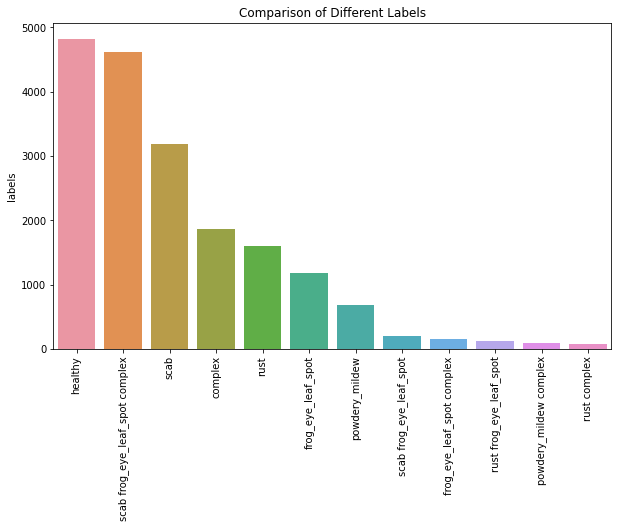

In [4]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.title("Comparison of Different Labels")
sns.barplot(x=labels, y=value_counts)

### Take a look at the labels!

An image may belong to one class or multiple classes. So, in short we have 6 classes of labels. Out of these 6 classes, there are 5 diseases, namely:

* scab
* complex
* rust
* frog eye leaf spot
* powdery mildew

The remaining one label is "healthy" which is pretty much self explanatory

This is a multi-label classification problem as one image can represent more than one class of diseases.

Let's have a look at some of the images

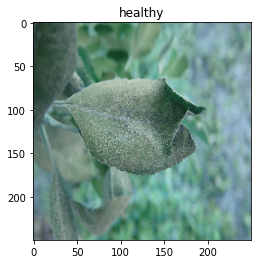

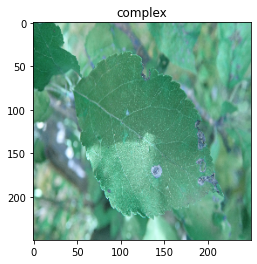

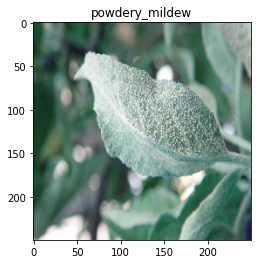

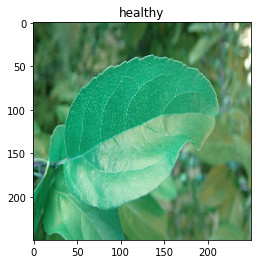

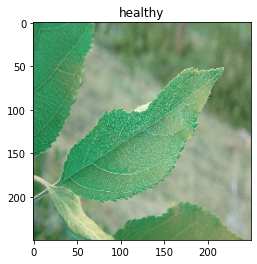

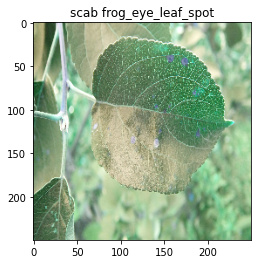

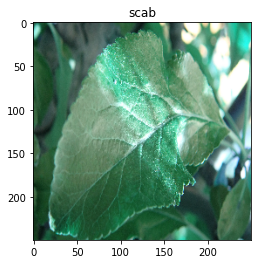

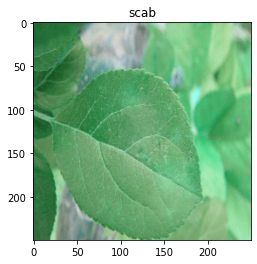

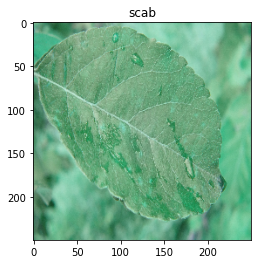

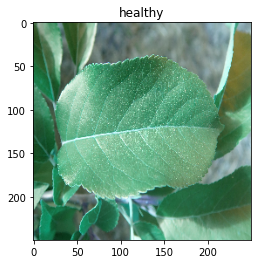

In [5]:
IMG_SIZE = 250

for i in range(0, 100, 10):
    img_array = cv2.imread(TRAIN_IMG_DIR + train_data['image'][i])
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(new_array)
    plt.title(train_data['labels'][i])
    plt.show()

We might as well look at the individual label comparison with each other. I will create a copy of my training data as I don't want to make changes to original training data

In [6]:
dummy_train_data = train_data
dummy_train_data = dummy_train_data['labels'].str.split(" ", expand=True).stack()
label_dummies = pd.get_dummies(dummy_train_data).groupby(level=0).sum()

We have converted the categorical data via dummy variable from pandas

In [7]:
label_dummies.head()

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,0,0,1,0,0,0
1,1,1,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0


So far so good. Let's plot the labels and their occurrence in the training images

In [8]:
cols = label_dummies.columns
label_counts = label_dummies[cols].sum()

<AxesSubplot:title={'center':'Comparison of all unique Labels'}>

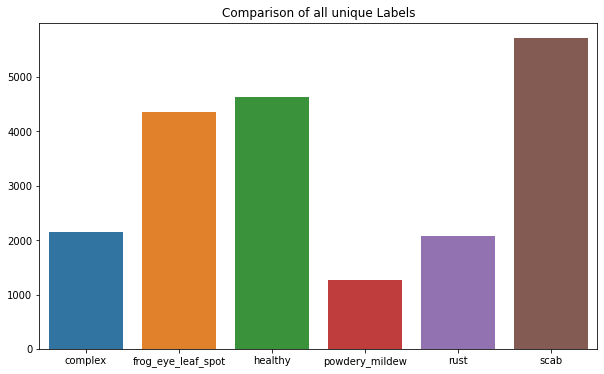

In [9]:
plt.figure(figsize=(10, 6))
plt.title("Comparison of all unique Labels")
sns.barplot(x=cols, y=label_counts)

## Problem with the original image size

The image sizes of all the training images is very high. I encountered two issues due to that:

1. While the model was getting trained, most of the CPU time was used to load the images. Due to that, a single epoch took somewhere around 45 mins. GPU was getting used but the main lag was due to the CPU which was busy loading the images from the dataset

2. When I tried downsizing the images to a lower resolution, my RAM got used fully and I was not able to continue ahead. Plus, it also took a lot of time to downsize 18632 images.

Therefore, I will be using a resized images dataset ([link to the dataset](https://www.kaggle.com/ankursingh12/resized-plant2021))

Also, we need the labels of training data in a comma separated fashion

In [10]:
train_data['labels'] = train_data['labels'].str.split(" ")

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
final_train_data = datagen.flow_from_dataframe(train_data,
    directory='/kaggle/input/resized-plant2021/img_sz_512',
    x_col="image",
    y_col="labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

Found 16769 validated image filenames belonging to 6 classes.


In [11]:
validation_data = datagen.flow_from_dataframe(train_data,
    directory='/kaggle/input/resized-plant2021/img_sz_512',
    x_col="image",
    y_col="labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")

Found 1863 validated image filenames belonging to 6 classes.


In [12]:
test_data['labels'] = test_data['labels'].str.split(" ")

test_datagen = ImageDataGenerator(rescale=1./255)

final_test_data = test_datagen.flow_from_dataframe(test_data,
    directory='/kaggle/input/testdata/Test',
    x_col="image",
    y_col="labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False)

Found 1000 validated image filenames belonging to 6 classes.


## Model Creation and Fitting

I will be using InceptionResNetV2 pre-trained model. In addition to this, I will be adding a GlobalAveragePooling2D layer and one last Dense layer with 6 nodes, one for each class with 'sigmoid' as activation, one node for each label(this is a multilabel classification problem)

In [13]:
weights = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_weight_model = InceptionResNetV2(
    include_top=False,
    weights=weights,
    input_shape=(256, 256, 3)
)

In [14]:
len(pretrained_weight_model.layers)

780

In [15]:
pretrained_weight_model.input
pretrained_weight_model.output

<KerasTensor: shape=(None, 6, 6, 1536) dtype=float32 (created by layer 'conv_7b_ac')>

In [16]:
for layer in pretrained_weight_model.layers[:630]:
    layer.trainable = False
for layer in pretrained_weight_model.layers[630:]:
    layer.trainable = True


##  F1 score as metrics

Since it is a multilabel image classification, I will be going for F1 accuracy instead of binary accuracy in macro mode. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally)

In [17]:
final_model = Sequential([
    pretrained_weight_model,
    GlobalAveragePooling2D(),
    Dense(units=6, activation = 'sigmoid')
])

final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 22,450,598
Non-trainable params: 31,895,360
_________________________________________________________________


Let's create a callback to prevent overfitting/underfitting

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

f1_score = tfadd.metrics.F1Score(num_classes=6, average='macro')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

final_model.compile(loss='binary_crossentropy', optimizer=Adam(epsilon=0.01), 
              metrics= [f1_score])

final_model_save = ModelCheckpoint('weights.h5' , 
                                    save_best_only = True,
                                   save_weights_only=True,
                                   monitor='val_loss',mode='min',verbose=1)

In [19]:
history = final_model.fit(final_train_data, epochs=10, 
        callbacks=early_stopping, validation_data=validation_data)

Epoch 1/10
525/525 [==============================] - 192s 338ms/step - loss: 0.3977 - f1_score: 0.3876 - val_loss: 0.2077 - val_f1_score: 0.7190
Epoch 2/10
525/525 [==============================] - 106s 201ms/step - loss: 0.1735 - f1_score: 0.7744 - val_loss: 0.2446 - val_f1_score: 0.7266
Epoch 3/10
525/525 [==============================] - 106s 202ms/step - loss: 0.1226 - f1_score: 0.8429 - val_loss: 0.1771 - val_f1_score: 0.7753
Epoch 4/10
525/525 [==============================] - 106s 201ms/step - loss: 0.0886 - f1_score: 0.8885 - val_loss: 0.2079 - val_f1_score: 0.7273
Epoch 5/10
525/525 [==============================] - 106s 201ms/step - loss: 0.0701 - f1_score: 0.9114 - val_loss: 0.2071 - val_f1_score: 0.7763
Epoch 6/10
525/525 [==============================] - 106s 203ms/step - loss: 0.0510 - f1_score: 0.9299 - val_loss: 0.2558 - val_f1_score: 0.7446


## Analysis of scores

1. loss vs f1 score
2. validation loss vs validation f1 score

In [20]:
print(history.history.keys())

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


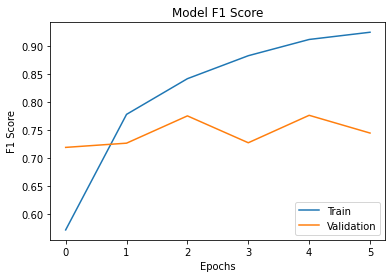

In [21]:
# 'F1 Score'

plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc='lower right')
plt.show()

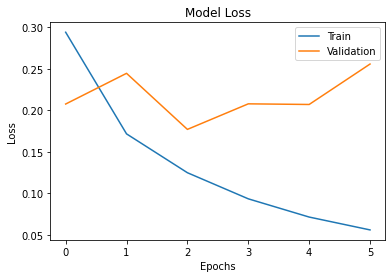

In [22]:
# 'Loss'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

Let's now predict on the test images that we have. Firstly, I will resize the images to 256X256 and then predict the values on it.

In [23]:
final_test_data.classes

[[0],
 [3, 0],
 [1],
 [0],
 [2],
 [2],
 [2],
 [2],
 [3],
 [1],
 [1],
 [5],
 [2],
 [3],
 [2],
 [2],
 [4],
 [2],
 [5, 1],
 [5],
 [0],
 [5],
 [5, 1],
 [5],
 [5],
 [2],
 [5],
 [5],
 [2],
 [2],
 [2],
 [5],
 [1],
 [2],
 [0],
 [1],
 [2],
 [2],
 [5],
 [3],
 [4],
 [1],
 [4],
 [2],
 [2],
 [4],
 [2],
 [0],
 [1],
 [1],
 [5, 1],
 [5],
 [2],
 [4],
 [5],
 [2],
 [5],
 [2],
 [5],
 [3],
 [2],
 [1],
 [2],
 [2],
 [1],
 [5],
 [5],
 [5],
 [2],
 [5],
 [2],
 [1],
 [2],
 [2],
 [5, 1],
 [1],
 [5],
 [2],
 [2],
 [5],
 [2],
 [2],
 [2],
 [1],
 [5],
 [3],
 [2],
 [1],
 [4],
 [2],
 [0],
 [5, 1],
 [5],
 [5],
 [1],
 [5, 1],
 [2],
 [5],
 [2],
 [2],
 [2],
 [5, 1],
 [3],
 [5, 1],
 [5],
 [1],
 [0],
 [4],
 [2],
 [4],
 [5],
 [2],
 [0],
 [5],
 [3, 0],
 [5],
 [1],
 [2],
 [5, 1, 0],
 [2],
 [5],
 [2],
 [2],
 [5],
 [0],
 [2],
 [2],
 [2],
 [1],
 [5],
 [4],
 [2],
 [2],
 [5],
 [2],
 [0],
 [5],
 [1],
 [2],
 [4],
 [5],
 [5],
 [1],
 [2],
 [3],
 [5],
 [5],
 [2],
 [3],
 [5],
 [5],
 [5],
 [5],
 [5],
 [1],
 [2],
 [3],
 [5, 1, 0],
 [2],
 [2]

In [24]:
len(final_test_data.classes)

1000

In [25]:
pred_data = final_model.predict(final_test_data)

In [26]:
pred_data

array([[7.2136410e-02, 1.5560490e-02, 1.8015181e-04, 2.4345350e-04,
        9.8158193e-01, 1.6914246e-03],
       [8.0667216e-01, 8.8402949e-02, 6.3646142e-03, 8.1801164e-01,
        4.7466727e-03, 3.2769628e-02],
       [8.7595982e-03, 9.9761474e-01, 3.2065972e-04, 4.2325766e-05,
        8.2690577e-04, 1.6936805e-02],
       ...,
       [6.0834009e-03, 1.7486300e-02, 5.7643021e-05, 1.1292878e-04,
        9.9686277e-01, 7.5894559e-04],
       [2.8538797e-02, 2.5525948e-01, 1.2775034e-03, 5.6997035e-04,
        2.0884504e-03, 9.7576946e-01],
       [3.3834661e-04, 4.9770472e-04, 9.7596824e-01, 1.1876702e-04,
        1.7385633e-04, 1.6735200e-02]], dtype=float32)

In [27]:
pred_lst = pred_data.tolist()

In [28]:
index_list = []

for pred in pred_lst:
    index = []
    for value in pred:
        if value >= 0.3:
            index.append(pred.index(value))
    if index != []:
        index_list.append(index)
    else:
        index.append(np.argmax(pred))
        index_list.append(index)

In [30]:
index_list

[[4],
 [0, 3],
 [1],
 [5],
 [2],
 [2],
 [2],
 [2],
 [3],
 [1],
 [1],
 [5],
 [2],
 [3],
 [2],
 [2],
 [4],
 [2],
 [0, 1, 5],
 [5],
 [0],
 [5],
 [1, 5],
 [5],
 [5],
 [2],
 [5],
 [5],
 [2],
 [2],
 [2],
 [5],
 [1],
 [2],
 [0, 4],
 [1],
 [2],
 [2],
 [5],
 [3],
 [4],
 [1],
 [4],
 [2],
 [2],
 [4],
 [2],
 [0, 1, 5],
 [1],
 [1],
 [0, 5],
 [5],
 [2],
 [4],
 [5],
 [2, 5],
 [5],
 [2],
 [5],
 [3],
 [5],
 [1],
 [2],
 [2],
 [1],
 [5],
 [5],
 [5],
 [2],
 [5],
 [2],
 [1],
 [2],
 [2],
 [1, 5],
 [1],
 [5],
 [2],
 [2],
 [5],
 [2],
 [2],
 [2],
 [1],
 [5],
 [3],
 [2],
 [1],
 [4],
 [2],
 [0, 1],
 [0, 1, 5],
 [5],
 [5],
 [0],
 [5],
 [2],
 [5],
 [2],
 [2],
 [2],
 [0, 1, 5],
 [3],
 [5],
 [5],
 [1],
 [5],
 [4],
 [2],
 [4],
 [5],
 [2],
 [0, 5],
 [2],
 [0],
 [5],
 [1],
 [2],
 [1, 5],
 [2],
 [5],
 [2],
 [2],
 [5],
 [0],
 [2],
 [2],
 [2],
 [1, 4],
 [5],
 [4],
 [2, 5],
 [2],
 [0, 5],
 [2],
 [1],
 [5],
 [1],
 [2],
 [4],
 [5],
 [5],
 [1],
 [2],
 [3],
 [5],
 [5],
 [2, 5],
 [3],
 [5],
 [5],
 [5],
 [5],
 [5],
 [1],
 [2],
 

In [31]:
len(index_list)

1000

In [32]:
pred_labels = final_train_data.class_indices
pred_labels = dict((value, key) for key, value in pred_labels.items())

pred_label_names = []

for indices in index_list:
    index = []
    for i in indices:
        index.append(str(pred_labels[i]))
    pred_label_names.append(' '.join(index))

In [33]:
pred_label_names[0:10]

['rust',
 'complex powdery_mildew',
 'frog_eye_leaf_spot',
 'scab',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'powdery_mildew',
 'frog_eye_leaf_spot']

In [34]:
final_model.evaluate(final_test_data)

32/32 [==============================] - 5s 161ms/step - loss: 0.0843 - f1_score: 0.8937


[0.08434637635946274, 0.8937031626701355]

In [35]:
def label_to_sm(labels, n_classes):
    sm = lil_matrix((len(labels), n_classes))
    for i, label in enumerate(labels):
        sm[i, label] = 1
    return sm

In [36]:
from scipy.sparse import lil_matrix

In [37]:
y_true_sm = label_to_sm(labels=final_test_data.classes, n_classes=6)
y_true_sm.toarray()

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.]])

In [38]:
y_pred_sm = label_to_sm(labels=index_list, n_classes=6)
y_pred_sm.toarray()

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.]])

In [40]:
from sklearn.metrics import f1_score
f1_score(y_true_sm , y_pred_sm, average='macro')

0.8958759595445661

In [41]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print('Confusion Matrix: ')
cm = multilabel_confusion_matrix(y_true_sm , y_pred_sm)
print(cm)
print(classification_report(y_true_sm , y_pred_sm, digits=5))

Confusion Matrix: 
[[[866  30]
  [ 19  85]]

 [[768  43]
  [ 15 174]]

 [[640  13]
  [  5 342]]

 [[955   2]
  [  2  41]]

 [[889  14]
  [  2  95]]

 [[647  59]
  [ 10 284]]]
              precision    recall  f1-score   support

           0    0.73913   0.81731   0.77626       104
           1    0.80184   0.92063   0.85714       189
           2    0.96338   0.98559   0.97436       347
           3    0.95349   0.95349   0.95349        43
           4    0.87156   0.97938   0.92233        97
           5    0.82799   0.96599   0.89168       294

   micro avg    0.86379   0.95065   0.90514      1074
   macro avg    0.85957   0.93706   0.89588      1074
weighted avg    0.86749   0.95065   0.90638      1074
 samples avg    0.91567   0.96067   0.92687      1074



In [42]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb=MultiLabelBinarizer()
mlb.fit_transform(final_test_data.classes)

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


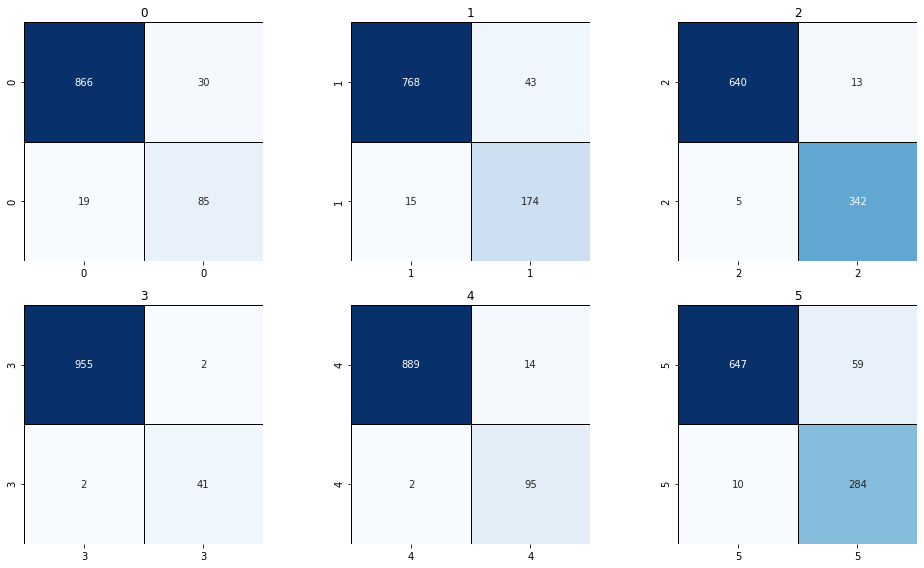

In [43]:
fig = plt.figure(figsize = (14, 8))
for i, (label, matrix) in enumerate(zip(mlb.classes_, cm)):
    plt.subplot(f'23{i+1}')
    labels = [f'{label}', label]
    sns.heatmap(matrix, annot = True, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()